# Task description

Goal:
- Build AEM electrolyzer system identification tool.

Given data:
- Electrolyzer stack voltage and current over time.

Plan:
1. Build electrolyzer model (= parametric equation of polarization curve).
2. Determine model parameters using part of given data.
3. Ensure parameters are correct using the other part of given data.

Electrolysis cell potential:
$$
E_{cell} = E_{rev} + E_{ohmic} + E_{activation} + E_{mass\_transfer}
$$
<img src="img/polarization-curve-detailed.png" width="40%"/>

### Reversible potential
> Source: https://doi.org/10.1016/j.ijhydene.2023.08.181 . But water activity $a_{\text{H}_2\text{O,KOH}}$ equation is incorrect in the source (lol. and what even more funny: numerous papers also contains this incorrect equation), so I took it from https://doi.org/10.1016/0360-3199(85)90093-X 

The reversible thermodynamic cell voltage, $E_{\text{rev}}$, is found using, which considers the effect of temperature, $T$, normalized partial pressures of the products, $P_{\text{H}_2}$ and $P_{\text{O}_2}$, and the activity of water, $a_{\text{H}_2\text{O}}$:
$$
E_{\text{rev}} = E_{\text{rev},T}^0 + \frac{RT}{2F} \ln \left( \frac{P_{\text{H}_2} \sqrt{P_{\text{O}_2}}}{a_{\text{H}_2\text{O}}} \right)
$$

When electrolysis is performed in KOH electrolytes (which are often used in the anode and cathode chambers of AEM water electrolyzers), the activities of $\text{H}_2$, $\text{O}_2$ and $\text{H}_2\text{O}$ are influenced by the properties of the KOH electrolyte:
$$
E_{\text{rev}} = E_{\text{rev},T}^0 + \frac{RT}{2F} \ln \left( \frac{(P - P_{\text{v,KOH}}) \sqrt{(P - P_{\text{v,KOH}})}}{a_{\text{H}_2\text{O,KOH}}} \right)
$$
where the ideal gas constant, $R = 8.314\ \text{J mol}^{-1}\text{K}^{-1}$, Faraday's constant, $F = 96,485\ \text{C mol}^{-1}$, $T$ is temperature (in K), $P$ is the operating pressure (in bar), $P_{\text{v,KOH}}$ is the water vapour pressure, and $a_{\text{H}_2\text{O,KOH}}$ is water activity in the KOH electrolyte. $E_{\text{rev},T}^0$ is the reversible voltage at standard pressure (1 bar), and is a function of temperature:
$$
E_{\text{rev},T}^0 = 1.5184 - 1.5421 \times 10^{-3} (T) + 9.523 \times 10^{-5} (T) \ln(T) + 9.84 \times 10^{-8} (T^2)
$$

The vapour pressure and the activity of water in KOH can be found by:
$$
P_{\text{v,KOH}} = e^{(2.302a + b \ln(P_{\text{v,H}_2\text{O}}))}
$$
$$
a = -0.0151m - 1.6788 \times 10^{-3}m^2 + 2.2588 \times 10^{-5}m^3
$$
$$
b = 1 - 1.2062 \times 10^{-3}m + 5.6024 \times 10^{-4}m^2 - 7.8228 \times 10^{-6}m^3
$$
$$
P_{\text{v,H}_2\text{O}} = \exp \left( \frac{81.6179 - 7699.68}{T} - 10.9 \ln(T) + 9.5891 \times 10^{-3} (T) \right)
$$
$$
a_{\text{H}_2\text{O,KOH}} = \exp \left( -0.02255 m + 0.001434 m^2 + \frac{1.38  m - 0.9254 m^2}{T} \right)
$$
where $m$ is the molar concentration of KOH (in mol $L^{-1}$).




In [1]:
import numpy as np
from scipy.optimize import curve_fit
from scipy import constants
import matplotlib.pyplot as plt
from lmfit import Model, Parameters
import pandas as pd


In [2]:
def E_rev(T, P=35, m=1/5.61):
    # m -- molar concentration of KOH in mol/L. Mass concentration of KOH in Enapter electrolyzer = 1% => m = 1/5.61
    # P = 35 bar, from the Enapter docs 

    
    # Constants
    R = constants.R # J/(mol*K)
    F = constants.e * constants.N_A # C/mol

    E_rev_T0 = 1.5184 - 1.5421 * 10**(-3) * T + 9.523 * 10**(-5) * T * np.log(T) + 9.84 * 10**(-8) * T**2

    Pv_H2O = np.exp(81.6179 - 7699.68 / T - 10.9 * np.log(T) + 9.5891 * 10**(-3) * T)
    
    a = -0.01508*m - 1.6788 * 10**(-3) * m**2 + 2.2589 * 10**(-5) * m**3
    b = 1 - 1.2062 * 10**(-3) * m + 5.6024 * 10**(-4) * m**2 - 7.8228 * 10**(-6) * m**3
    
    Pv_KOH = np.exp(2.302 * a + b * np.log(Pv_H2O))
    
    # WRONG Calculation of aH2O,KOH 
    # WRONG_aH2O_KOH = -0.05192 * m + 0.003302 * m**2 + (3.177 * m - 2.131 * m**2) / T
    # print(WRONG_aH2O_KOH)
    
    aH2O_KOH = np.exp(-0.02255 * m + 0.001434 * m ** 2 + (1.38 * m - 0.9254* m**2) / T)
    
    E_rev = E_rev_T0 + (R * T / (2 * F)) * np.log((P - Pv_KOH) * np.sqrt(P - Pv_KOH) / aH2O_KOH)

    return E_rev

In [3]:
print("m=0, E_rev=", E_rev(T=330, P=35, m=0))
print("m=0.1, E_rev=", E_rev(T=330, P=35, m=0.1))
print("m=1, E_rev=", E_rev(T=330, P=35, m=1))
print("m=5, E_rev=", E_rev(T=330, P=35, m=5))
print("m=10, E_rev=", E_rev(T=330, P=35, m=10))
print("m=50, E_rev=", E_rev(T=330, P=35, m=50))

# why do we need KOH electrolyte at all??

m=0, E_rev= 1.2781874938612912
m=0.1, E_rev= 1.2782141535070641
m=1, E_rev= 1.2784720107317595
m=5, E_rev= 1.2800058075527758
m=10, E_rev= 1.2828027547070981
m=50, E_rev= 1.3400579728873705


### Ohmic overpotential
> was helpful: https://doi.org/10.1016/j.jpowsour.2005.11.099

The voltage drop due to ohmic resistance can be found using:

$$
E_{\text{ohmic}} = j \times r
$$

where $j$ -- current density [A $m^{-2}$], $r$ -- cell resistance density [Ohm $m^{2}$].

In [4]:
def E_ohmic(j, r):
    return j*r

### Activation overpotential
> Equations (20)-(23) from https://sci-hub.ru/10.1016/j.pecs.2009.11.002

The activation overpotentials for the oxygen evolution reaction (OER) (on cathode) and hydrogen evolution reaction (HER) (on anode) can be found using the Tafel equation:

(Should 2 be taken as the stoichiometric coefficient here?)
$$
\eta_{\text{cathode}} = \frac{RT}{2 \alpha F} \ln \left(\frac{j}{j_0}\right)
$$

$$
\eta_{\text{anode}} = \frac{RT}{2 (1 - \alpha) F} \ln \left(\frac{j}{j_0}\right)
$$

where $j$ is current density [A $m^{-2}$], $j_0$ is exchange current density [A $m^{-2}$].

Thus, 
$$
E_{activation} = \eta_{\text{cathode}} + \eta_{\text{anode}}
$$


In [5]:
def E_activation(T, j, alpha, j_0):
    # Constants
    R = constants.R # J/(mol*K)
    F = constants.e * constants.N_A # C/mol
    
    # Calculate overpotentials
    eta_cathode = (R * T / (2* alpha * F)) * np.log(j / j_0)
    eta_anode = (R * T / (2*(1- alpha) * F)) * np.log(j / j_0)
    
    return eta_cathode + eta_anode

### Bubbles' overpotential

> Eq (19)-(23) from https://doi.org/10.1016/j.ijhydene.2017.08.183 . But because in our case AEM considered instead of PEM, we only consider the Buttler-Volmer expression on the CATHODE side

$$
\eta_{\text{bub, cathode}} = \frac{RT}{ 2 \alpha F} \left(\frac{j}{j_s}\right)^2
$$

Should 2 as stoichiometric coefficient be taken here?

In [6]:
def E_bub(T, j, alpha, j_s):
    # Constants
    R = constants.R # J/(mol*K)
    F = constants.e * constants.N_A # C/mol
    
    # Calculate overpotentials
    eta_bub = (R * T / (2* alpha * F)) * (j / j_s)**2
    return eta_bub

Finally, cell polarization curve equation:

In [7]:
def E_cell(j, T, j_0, j_s, alpha, r):
    return E_rev(T) + E_ohmic(j, r) + E_activation(T, j, alpha, j_0) + E_bub(T, j, alpha, j_s)


def draw_polarization_curves(j_values, j_0, j_s, alpha, r, I_measured, V_measured, T_measured):
    T_mean = np.percentile(T_measured, 50)
    
    E_rev_values = np.full_like(j_values, E_rev(T_mean))  # E_rev is constant
    E_ohmic_values = E_ohmic(j_values, r)
    E_activation_values = E_activation(T_mean, j_values, alpha, j_0)
    E_bub_values = E_bub(T_mean, j_values, alpha, j_s)
    E_values = E_cell(j_values, T_mean, j_0, j_s, alpha, r)
        
    # Plot the polarization curve
    plt.figure(figsize=(10, 6))
    plt.scatter(I_measured, V_measured,  marker='o', color='pink')
    plt.plot(j_values, E_values, label='Total Cell Potential LOW', color='lightblue', linewidth=2)
    plt.plot(j_values, E_values, label='Total Cell Potential UP', color='blue', linewidth=2)
    plt.plot(j_values, E_rev_values, '--', label='Reversible Potential', color='green', linewidth=1.5)
    plt.plot(j_values, E_ohmic_values, '--', label='Ohmic Overpotential', color='red', linewidth=1.5)
    plt.plot(j_values, E_activation_values, '--', label='Activation Overpotential', color='purple', linewidth=1.5)
    plt.plot(j_values, E_bub_values, '--', label='Bubbles Overpotential', color='orange', linewidth=1.5)

    # Make the plot pretty
    plt.title('Polarization Curve', fontsize=16)
    plt.xlabel('Current density j (A/m$^2$)', fontsize=14)
    plt.ylabel('Potential E (Volts)', fontsize=14)
    plt.grid(True)
    plt.legend(fontsize=12)
    plt.tight_layout()

    # Show the plot
    plt.show()

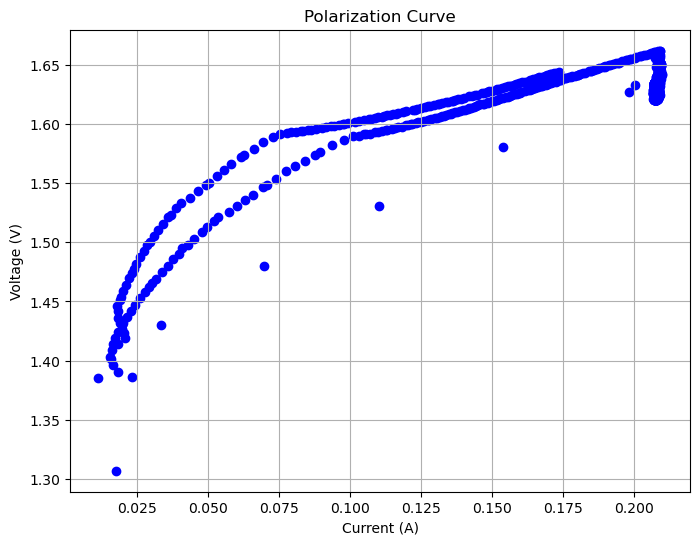

In [14]:
pre_EL3_df = pd.read_csv("measurements/Aug 1 experiment - EL3.csv", index_col=0, parse_dates=True)
pre_EL3_df.index = pre_EL3_df.index.tz_convert('US/Pacific').tz_localize(None)

unsorted_EL3_df = pre_EL3_df[(pre_EL3_df['HASS_in_a'] >= 2) & (pre_EL3_df['HASS_in_a'] <= 555)]
EL3_df = unsorted_EL3_df.sort_values(by='HASS_in_a', ascending=True)

# my approximation of the membrane surface area is 255 cm2
# this value is selected so that the operating current of the cell is approx 0.2 A/cm2, as in the source
# Enapter cells have round shape, so my assumption that membrane is 9cm diameter circle
# source: https://www.ammoniaenergy.org/articles/technology-status-anion-exchange-membrane-aem-electrolysis/
I_measured = EL3_df['HASS_in_a'].to_numpy()/255 
V_measured = EL3_df['PSU_in_v'].to_numpy()/25 # number of cells in stack
T_measured = EL3_df['TT102A_in_c'].to_numpy() + 273.15

plt.figure(figsize=(8, 6))
plt.scatter(I_measured, V_measured,  marker='o', color='blue')
plt.title('Polarization Curve')
plt.ylabel('Voltage (V)')
plt.xlabel('Current (A)')
plt.grid(True)
plt.show()

In [15]:
# E_cell(j, T, j_0, j_s, alpha, r)
model = Model(E_cell, independent_vars=['j', 'T'])

# Create parameters, with initial values and (optional) bounds
params = Parameters()
params.add('j_0', value=0.001, min=0, max=0.05)
params.add('j_s', value=30, min=0)
params.add('alpha', value=0.1, min=0, max=1)
params.add('r', value=0.5, min=5e-5, max=1)

# Fit the model to the data
result = model.fit(V_measured, j=I_measured, T=T_measured, params=params)

# Print the fitting results
print(result.fit_report())

# If you want to access the best-fit values directly
j_0_best = result.params['j_0'].value
j_s_best = result.params['j_s'].value
alpha_best = result.params['alpha'].value
r_best = result.params['r'].value

[[Model]]
    Model(E_cell)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 324
    # data points      = 2870
    # variables        = 4
    chi-square         = 0.35502532
    reduced chi-square = 1.2387e-04
    Akaike info crit   = -25815.2081
    Bayesian info crit = -25791.3598
    R-squared          = 0.83714566
[[Variables]]
    j_0:    0.00195762 +/- 1.7304e-04 (8.84%) (init = 0.001)
    j_s:    481096.957 +/- 1.3931e+14 (28955759436.29%) (init = 30)
    alpha:  0.24848223 +/- 0.01228402 (4.94%) (init = 0.1)
    r:      5.0000e-05 +/- 0.06274456 (125488.97%) (init = 0.5)
[[Correlations]] (unreported correlations are < 0.100)
    C(j_0, alpha) = -0.9803
    C(alpha, r)   = -0.9667
    C(j_0, r)     = +0.8977


C:\Users\Rostyslav Kirchev\AppData\Local\Temp\ipykernel_10152\266452547.py:7: RuntimeWarning: divide by zero encountered in log
  eta_cathode = (R * T / (2* alpha * F)) * np.log(j / j_0)
C:\Users\Rostyslav Kirchev\AppData\Local\Temp\ipykernel_10152\266452547.py:8: RuntimeWarning: divide by zero encountered in log
  eta_anode = (R * T / (2*(1- alpha) * F)) * np.log(j / j_0)


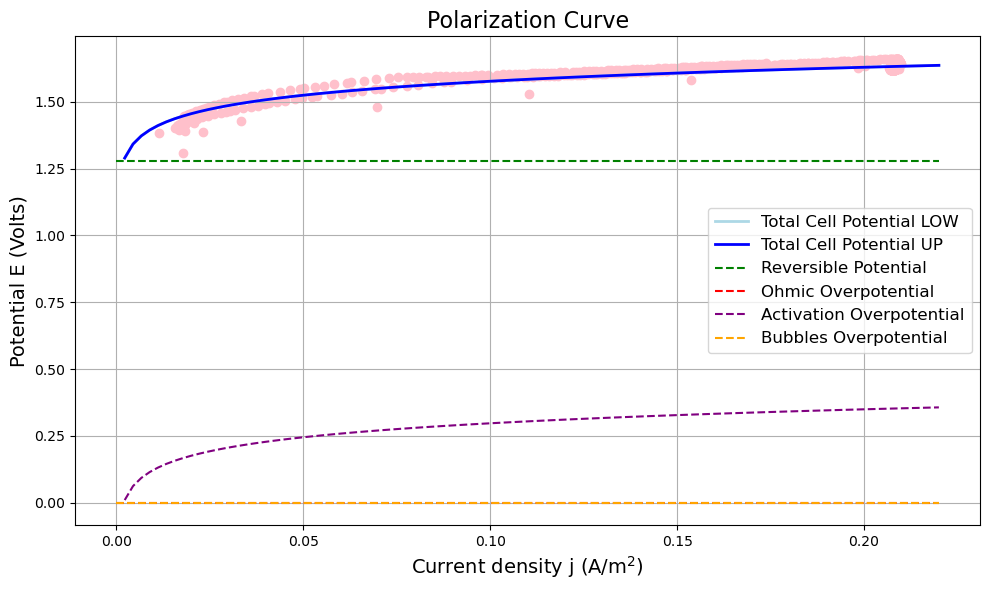

In [16]:
j_values = np.linspace(0, 0.22, 100)

draw_polarization_curves(j_values, j_0_best, j_s_best, alpha_best, r_best, I_measured, V_measured, T_measured)